In [1]:
#!pip install pillow
#!pip install tensorflow-io
#!pip install -U dicomsdl
#!pip install pydicom

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import io
import gc
import pydicom
from pydicom import dcmread
import random
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
train_img_path = "/kaggle/input/rsna-breast-cancer-detection/train_images"
train_csv_path = "/kaggle/input/rsna-breast-cancer-detection/train.csv"

**Setup TPU**

In [4]:
'''
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()
'''

"\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  \n    print('Running on TPU ', tpu.master())\nexcept ValueError:\n    tpu = None\n\nif tpu:\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nelse:\n    strategy = tf.distribute.MirroredStrategy()\n"

In [4]:
images = [] 
labels = []
img_size = [512,256]

df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

num_images_per_label = 320 #evaluation
transient = 100 #evaluation
patient_ids = os.listdir(train_img_path)

In [5]:
def crop_image(img):
        threshold = ((img > np.mean(img))*255).astype(np.uint8)
        contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        # crop
        return img[y:y+h, x:x+w]

In [6]:
def preprocess_image(image):
    arr = image.pixel_array.astype(float)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    if image.PhotometricInterpretation == "MONOCHROME1":
        arr = 1 - arr
    arr = crop_image(arr)
    arr = cv2.resize(arr, (img_size[1],img_size[0]),interpolation = cv2.INTER_AREA)
    arr = np.stack((arr,)*3,axis=2)
    return arr

(5355, 4915, 3)


(-0.5, 255.5, 511.5, -0.5)

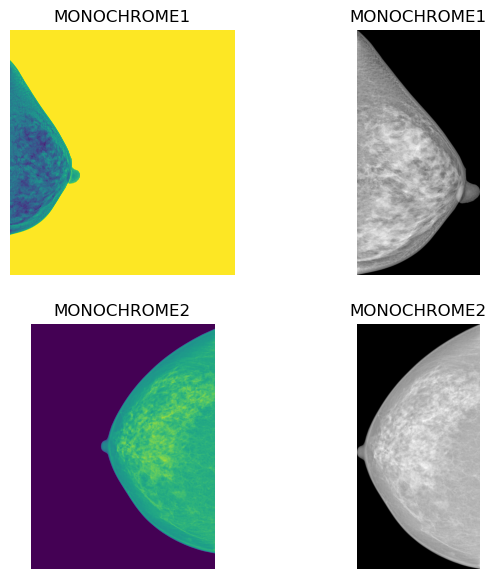

In [7]:
plt.figure(figsize=(7, 7))

mono1=dcmread('/kaggle/input/rsna-breast-cancer-detection/train_images/10051/1238319934.dcm')
arr = mono1.pixel_array
arr = np.stack((arr,)*3,axis=2)
print(arr.shape)
ax = plt.subplot(2,2,1)
plt.title(mono1.PhotometricInterpretation)
plt.imshow(arr[:,:,1])
plt.axis('off')

mono2 = dcmread('/kaggle/input/rsna-breast-cancer-detection/train_images/10219/1331256002.dcm')
arr1 = mono2.pixel_array
arr1 = np.stack((arr1,)*3,axis=2)
ax = plt.subplot(2,2,3)
plt.title(mono2.PhotometricInterpretation)
plt.imshow(arr1[:,:,1])
plt.axis('off')

arr = preprocess_image(mono1)    
ax = plt.subplot(2,2,2)
plt.title(mono1.PhotometricInterpretation)
plt.imshow(arr[:,:,1],cmap='gray')
plt.axis('off')

arr1 = preprocess_image(mono2)
ax = plt.subplot(2,2,4)
plt.title(mono2.PhotometricInterpretation)
plt.imshow(arr1[:,:,1],cmap="gray")
plt.axis('off')

Negative labels only:

In [ ]:
i=0
for index, row in df.iterrows():
    pid = str(row['patient_id'])
    if i<transient:
        i+=1
        continue
    canc = row['cancer']
    if canc == 1:
        continue
    
    current_dir=train_img_path+"/"+pid
    corrupted = False
    
    for img_id in os.listdir(current_dir):
        current_dir=train_img_path+"/"+pid+"/"+img_id

        try:
            img = dcmread(current_dir)
            arr = preprocess_image(img)
        except:
            corrupted = True
            break

        images.append(np.array(arr))
        labels.append(canc)
    
    if not corrupted: 
        print(i)
        i+=1
    
    if i>num_images_per_label+transient:
        break

Positive Labels only:

In [ ]:
i=0
for index, row in df.iterrows():
    if i<transient:
        i+=1
        continue
    pid = str(row['patient_id'])
    
    canc = row['cancer']
    if canc == 0:
        continue
    
    current_dir=train_img_path+"/"+pid
    corrupted = False
    
    for img_id in os.listdir(current_dir):
        current_dir=train_img_path+"/"+pid+"/"+img_id

        try:
            img = dcmread(current_dir)
            arr = preprocess_image(img)
        except:
            corrupted = True
            break

        images.append(np.array(arr))
        labels.append(canc)
    
    if not corrupted: 
        print(i)
        i+=1
    
    if i>num_images_per_label+transient:
        break

In [10]:
labels = np.array(labels,dtype=np.int64) 
images = np.array(images)
images, labels = shuffle(images,labels,random_state=57)

85/85 [==============================] - 1194s 14s/step
Accuracy =  0.5791420118343196


<Axes: >

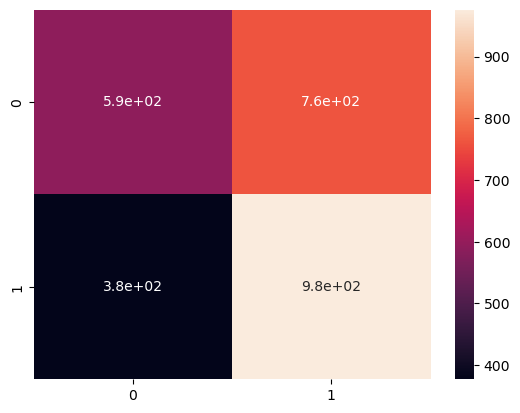

In [15]:
#evaluation..
model = tf.keras.models.load_model('/kaggle/input/fmodel2/final_model2.h5')

predictions = model.predict(images)
y_pred = (predictions>= 0.5).astype(int)[:,0]

print ("Accuracy = ", metrics.accuracy_score(labels, y_pred))
cm=confusion_matrix(labels, y_pred)  
sns.heatmap(cm, annot=True)

In [12]:
gc.collect()

0

In [13]:
unique, counts = np.unique(labels, return_counts=True)
cancer_class_counts = dict(zip(unique, counts))
print('Cancer : ', cancer_class_counts)

Cancer :  {0: 276, 1: 282}


In [14]:
'''
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal"),#,input_shape=(img_size[0],img_size[1],3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

minor_class = min(cancer_class_counts, key=cancer_class_counts.get)
major_class = max(cancer_class_counts, key=cancer_class_counts.get)

img_to_augment = images[labels==minor_class]

n = cancer_class_counts[major_class]-cancer_class_counts[minor_class]
indexes = np.random.randint(img_to_augment.shape[0], size=n)

new_images = []
new_labels = []
for i in range(n):
    augmented_image = data_augmentation(img_to_augment[indexes[i]])
    new_images.append(augmented_image)
    new_labels.append(minor_class)
    print(i)
'''

'\ndata_augmentation = tf.keras.Sequential(\n  [\n    layers.RandomFlip("horizontal"),#,input_shape=(img_size[0],img_size[1],3)),\n    layers.RandomRotation(0.1),\n    layers.RandomZoom(0.1),\n  ]\n)\n\n# Find the class to be augmented and the major one\nminor_class = min(cancer_class_counts, key=cancer_class_counts.get)\nmajor_class = max(cancer_class_counts, key=cancer_class_counts.get)\n\n# Select the images belonging to the class to augment\nimg_to_augment = images[labels==minor_class]\n\n# Select random indexes for the images to augment\nn = cancer_class_counts[major_class]-cancer_class_counts[minor_class]\nindexes = np.random.randint(img_to_augment.shape[0], size=n)\n\nnew_images = []\nnew_labels = []\nfor i in range(n):\n    augmented_image = data_augmentation(img_to_augment[indexes[i]])\n    new_images.append(augmented_image)\n    new_labels.append(minor_class)\n    print(i)\n'

In [15]:
gc.collect()

0

In [16]:
'''
balanced_images = np.append(images, new_images, axis=0)
balanced_labels = np.append(labels, new_labels, axis=0)

unique, counts = np.unique(balanced_labels, return_counts=True)
cancer_class_counts = dict(zip(unique, counts))
print('Cancer : ', cancer_class_counts)
'''

"\nbalanced_images = np.append(images, new_images, axis=0)\nbalanced_labels = np.append(labels, new_labels, axis=0)\n\nunique, counts = np.unique(balanced_labels, return_counts=True)\ncancer_class_counts = dict(zip(unique, counts))\nprint('Cancer : ', cancer_class_counts)\n"

In [17]:
'''
n=9
idx_toplot = np.random.randint(len(balanced_images), size=n)
plt.figure(figsize=(10, 10))
for i in range(n):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(balanced_labels[idx_toplot[i]])
    plt.imshow(balanced_images[idx_toplot[i]])
    plt.axis('off')
'''

"\nn=9\nidx_toplot = np.random.randint(len(balanced_images), size=n)\nplt.figure(figsize=(10, 10))\nfor i in range(n):\n    ax = plt.subplot(3, 3, i + 1)\n    plt.title(balanced_labels[idx_toplot[i]])\n    plt.imshow(balanced_images[idx_toplot[i]])\n    plt.axis('off')\n"

In [18]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, random_state=57)

In [19]:
'''
batch_size = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = num_training_images // batch_size
'''

'\nbatch_size = 16 * strategy.num_replicas_in_sync\nSTEPS_PER_EPOCH = num_training_images // batch_size\n'

In [20]:
#with strategy.scope():  
pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[img_size[0],img_size[1], 3])
pretrained_model.trainable = False

inputs = tf.keras.Input(shape=[img_size[0],img_size[1], 3])
x = tf.keras.layers.Conv2D(3, 3, activation='relu', padding='same')(inputs)
x = pretrained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

74836368/74836368 [==============================] - 0s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 256, 3)       84        
                                                                 
 densenet201 (Functional)    (None, 16, 8, 1920)       18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                             

In [22]:
gc.collect()

27057

In [ ]:
EPOCHS = 20
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
)

history1 = model.fit( x_train,
                     y_train,
                     epochs=EPOCHS, 
                     validation_data=(x_test,y_test)
                    )


Epoch 1/20
14/14 [==============================] - 644s 44s/step - loss: 0.7206 - accuracy: 0.5813 - val_loss: 0.5984 - val_accuracy: 0.6786
Epoch 2/20
14/14 [==============================] - 626s 44s/step - loss: 0.6617 - accuracy: 0.6722 - val_loss: 0.7126 - val_accuracy: 0.5286
Epoch 3/20
14/14 [==============================] - 586s 42s/step - loss: 0.7403 - accuracy: 0.5933 - val_loss: 0.5058 - val_accuracy: 0.7929
Epoch 4/20
14/14 [==============================] - 608s 44s/step - loss: 0.5364 - accuracy: 0.7153 - val_loss: 0.4362 - val_accuracy: 0.8000
Epoch 5/20
14/14 [==============================] - 585s 42s/step - loss: 0.4665 - accuracy: 0.7703 - val_loss: 0.6208 - val_accuracy: 0.7000
Epoch 6/20
14/14 [==============================] - 609s 44s/step - loss: 0.4243 - accuracy: 0.8062 - val_loss: 0.3511 - val_accuracy: 0.8571
Epoch 7/20
14/14 [==============================] - 585s 42s/step - loss: 0.3757 - accuracy: 0.8517 - val_loss: 0.2920 - val_accuracy: 0.8929
Epoch 

In [ ]:
model.save('final_model2.h5')

In [ ]:
'''
accuracy = []
for i in range(17):
    accuracy.append(history.history['accuracy'][i])
for j in range(len(history.history['accuracy'][18])):
    accuracy.append(history.history['accuracy'][18][j])
    
val_accuracy = []
for i in range(17):
    val_accuracy.append(history.history['val_accuracy'][i])
for j in range(len(history.history['val_accuracy'][18])):
    val_accuracy.append(history.history['val_accuracy'][18][j])
    
loss1 = history.history['loss']
for i in range(len(history1.history['loss'])):
    loss1.append(history1.history['loss'][i])
    
val_loss1 = history.history['val_loss']
for i in range(len(history1.history['val_loss'])):
    val_loss1.append(history1.history['val_loss'][i])
'''
print(accuracy[:25])

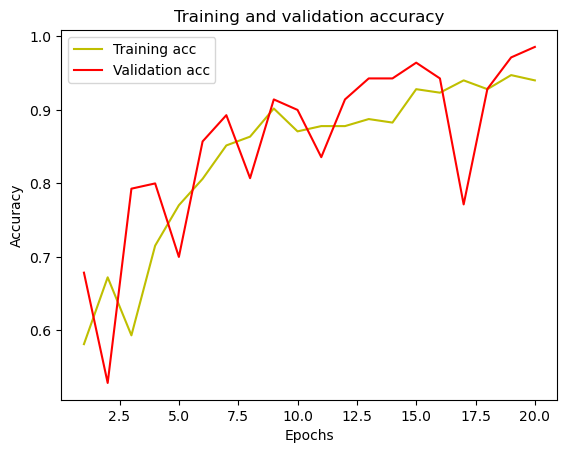

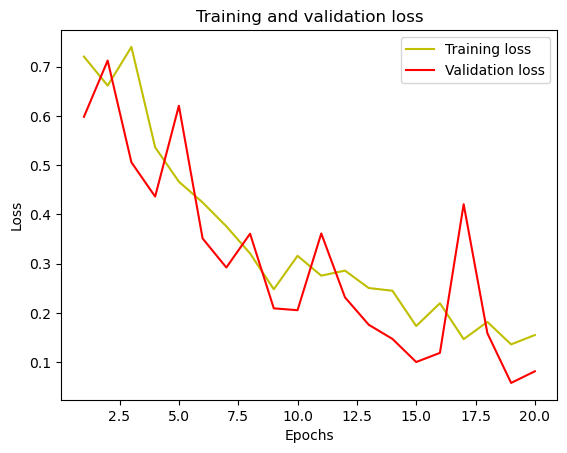

In [29]:
hist = history1
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

5/5 [==============================] - 58s 10s/step
Accuracy =  0.9857142857142858


<Axes: >

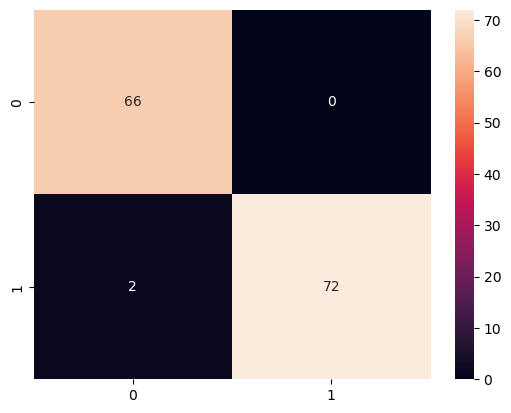

In [27]:
predictions = model.predict(x_test)
y_pred = (predictions>= 0.5).astype(int)[:,0]

print ("Accuracy = ", metrics.accuracy_score(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)  
sns.heatmap(cm, annot=True)